In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02_callbacks import *

# Initial Setup

In [134]:
x_train, y_train, x_valid, y_valid = get_data(url=MNIST_URL)
train_ds = Dataset(x=x_train, y=y_train)
valid_ds = Dataset(x=x_valid, y=y_valid)
nh = 50
bs = 16
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [135]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs=bs), c=c)

In [16]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [17]:
learner = create_learner(get_model, loss_func, data)
run = Runner(cbs=[AvgStatsCallback(metrics=[accuracy])])
run.fit(epochs=3, learner=learner)

epoch=[1/3]:	train: [0.349313125, tensor(0.8955)]	valid: [0.2347951904296875, tensor(0.9379)]
epoch=[2/3]:	train: [0.21327275390625, tensor(0.9416)]	valid: [0.1918232666015625, tensor(0.9496)]
epoch=[3/3]:	train: [0.18392302734375, tensor(0.9491)]	valid: [0.18071456298828126, tensor(0.9577)]


In [20]:
learner = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner(cbs=[AvgStatsCallback(metrics=[accuracy])])
run.fit(epochs=3, learner=learner)

epoch=[1/3]:	train: [0.2807528515625, tensor(0.9129)]	valid: [0.1918615478515625, tensor(0.9450)]
epoch=[2/3]:	train: [0.153882724609375, tensor(0.9548)]	valid: [0.1309697021484375, tensor(0.9631)]
epoch=[3/3]:	train: [0.127143310546875, tensor(0.9621)]	valid: [0.1352552490234375, tensor(0.9643)]


In [23]:
#export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)
    

# Annealing

```
We define two new callbacks:
1. a Recorder: to save track of the loss and our scheduled learning rate
2. a ParamScheduler: that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer
```

In [157]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs    = []
        self.losses = []
        
    def after_batch(self):
        if not self.in_train:
            return
        self.lrs.append(self.opt.param_groups[-1]["lr"])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self):
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)
        

class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func):
        self.pname      = pname
        self.sched_func = sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:
            ### print(self.sched_func, self.n_epochs, self.epochs)
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train:
            self.set_param()
            

```
Let's start with a simple linear schedule going from start to end.
It returns a function that takes a "pos" argument (going from 0 to 1) such that this function goes from "start" (at pos=0) to "end" (at pos=1) in a linear fashion.
```

In [31]:
def sched_linear(start, end, pos):
    def _inner(start, end, pos):
        return start + (end-start)*pos
    return partial(_inner, start, end)
        

```
We can refator the above sched_linear function using decorators so that we donot need to create a separate instance of sched_linear for every pos value
```

In [58]:
#export
def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner

@annealer
def sched_linear(start, end, pos):
    return start + (end-start)*pos


In [59]:
f = sched_linear(1,2)
f

functools.partial(<function sched_linear at 0x7f0f7d24ab00>, 1, 2)

In [60]:
f(pos=0.3)

1.3

In [61]:
f(0.3)

1.3

In [62]:
f(0.5)

1.5

```
Some more important acheduler functions
```

In [80]:
#export

@annealer
def sched_cos(start, end, pos):
    return start + (end-start) * (1 + math.cos(math.pi*(1-pos))) / 2.

@annealer
def sched_no(start, end, pos):
    return start

@annealer
def sched_exp(start, end, pos):
    return start * ((end/start) ** pos)
    

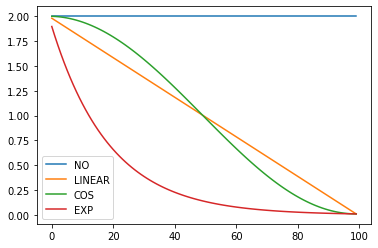

In [81]:
annealings = "NO LINEAR COS EXP".split(" ")

a = torch.arange(start=0, end=100)
p = torch.linspace(start=0.01, end=1, steps=100)

fns = [sched_no, sched_linear, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(start=2, end=1e-2)
    plt.plot(a, [f(i) for i in p], label=t)
plt.legend();

In [85]:
### in earlier version of Pytorch, a Tensor object did not had "ndim" attribute
### we can add any attribute to any Python object using property() function.
### here we are adding "ndim" attribute to Tensor object using the below monkey-patching

# torch.Tensor.ndim = property(lambda x: len(x.shape))

```
In practice we will want to use multiple schedulers and the below function helps us do that
```

In [161]:
#export

def combine_scheds(pcts, scheds):
    """
    pcts  : list of %ages of each scheduler
    scheds: list of all schedulers
    """
    assert sum(pcts) == 1
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(input=pcts, dim=0)
    def _inner(pos):
        """pos is a value b/w (0,1)"""
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](pos=actual_pos)
    return _inner


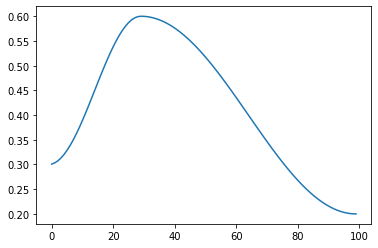

In [115]:
### Example of a learning rate scheduler annealing:
### using 30% of training budget to go from 0.3 to 0.6 using cosine scheduler
### using the rest 70% of the trainign budget to go from 0.6 to 0.2 using another cosine scheduler

sched = combine_scheds(pcts=[0.3, 0.7], scheds=[sched_cos(start=0.3, end=0.6), sched_cos(start=0.6, end=0.2)])
plt.plot(a, [sched(i) for i in p])

```
We can use it for trainign quite easily.
```

In [153]:
cbfs = [Recorder, 
        partial(AvgStatsCallback, metrics=accuracy),
        partial(ParamScheduler, pname="lr", sched_func=sched)]

In [154]:
cbfs

[__main__.Recorder,
 functools.partial(<class 'exp.nb_02_callbacks.AvgStatsCallback'>, metrics=<function accuracy at 0x7f0fc9ad1b90>),
 functools.partial(<class '__main__.ParamScheduler'>, pname='lr', sched_func=<function combine_scheds.<locals>._inner at 0x7f0f7d236050>)]

In [155]:
bs=512
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c=c)

In [156]:
learner = create_learner(model_func=get_model_func(lr=0.3), loss_func=loss_func, data=data)
run = Runner(cb_funcs=cbfs)
run.fit(epochs=2, learner=learner)


<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.01020408163265306 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.02040816326530612 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.030612244897959183 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.04081632653061224 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.0510204081632653 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.06122448979591836 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.07142857142857142 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.08163265306122448 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.09183673469387754 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.1020408163265306 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 0.11224489795918366 2
<function combine_scheds.<locals>._

<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.0816326530612237 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.0918367346938767 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1020408163265296 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1122448979591826 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1224489795918355 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1326530612244885 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1428571428571415 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1530612244897944 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1632653061224474 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1734693877551003 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1836734693877533 2
<function combine_scheds.<locals>._inner at 0x7f0f7d236050> 1.1938775510204063 2
<function combine_scheds.<lo

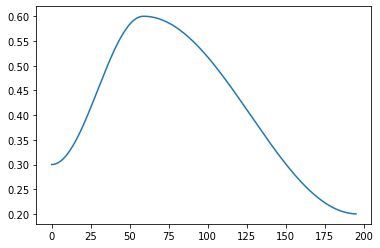

In [150]:
run.recorder.plot_lr()

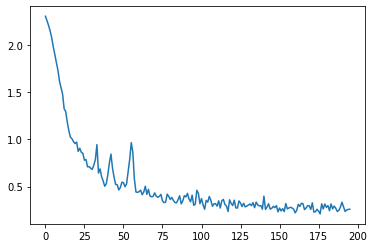

In [151]:
run.recorder.plot_loss()

# Export

In [166]:
!python notebook_to_script.py imflash217__02_anneal.ipynb

Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py
Converted imflash217__02_anneal.ipynb to exp/nb_02_anneal.py


In [94]:
pct = [0.3, 0.7]
pct = torch.tensor([0] + listify(pct))
pct = torch.cumsum(pct, 0)

In [100]:
pos = 2
(pos >= pct).nonzero().max()

tensor(2)